In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
DATA_PATH = 'cell_inference/resources'

INVIVO_PATH = os.path.join(DATA_PATH, 'cell360LFP2D.h5')

with h5py.File(INVIVO_PATH, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    print(f['coord'][:].shape)
    print(f['data'][:].shape)
    a_group_key = list(f.keys())[0]

    # Get the data
    test_data = f['data'][:]

Keys: <KeysViewHDF5 ['coord', 'data', 'fs', 'grid']>
(384, 2)
(121, 384)


In [3]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere


DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Loc2Alt_Ori2_Geo3_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

(1000, 176, 384)
(1000, 7)


In [4]:
from tqdm.notebook import tqdm

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

  0%|          | 0/1000 [00:00<?, ?it/s]

If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [5]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [6]:
import json

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
print(inference_list)
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
feature_range = (-1, 1)

normalize_labels = True

if normalize_labels:
    for i in range(labels.shape[1]):
        label = labels[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
        x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
        labels[:,i] = x_scaled
    print(labels)

['d', 'theta', 'h', 'phi', 'r_s', 'l_t', 'r_t']
[[-0.54532796  0.19950308  0.2467447  ...  0.78257079 -0.95830196
   0.01884223]
 [-0.36648332 -0.83769703 -0.33564824 ... -0.10318346 -0.03745967
  -0.99991956]
 [ 0.59473091  0.05853246 -0.31366349 ... -0.15249521  0.96449401
  -0.76405391]
 ...
 [-0.26264348 -0.37940062  0.95769607 ...  0.23478598  0.82764779
  -0.75374182]
 [-0.01424659 -0.12016722  0.92645932 ... -0.40433452  0.83934002
   0.84983729]
 [-0.1353533  -0.07019125  0.14896279 ...  0.81742647 -0.38685954
  -0.7928324 ]]


In [7]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(1000, 40)


In [9]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=7)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:01<05:22,  1.08s/it]

Training Loss: 114.41624193638563 Validation Loss: 33.24349159002304


  4%|▎         | 11/300 [00:10<04:37,  1.04it/s]

Training Loss: 82.15329130366445 Validation Loss: 28.67697463929653


  7%|▋         | 21/300 [00:21<04:54,  1.06s/it]

Training Loss: 75.39998754113913 Validation Loss: 27.08014841750264


 10%|█         | 31/300 [00:31<04:43,  1.06s/it]

Training Loss: 72.24378610774875 Validation Loss: 26.44069292396307


 14%|█▎        | 41/300 [00:42<04:32,  1.05s/it]

Training Loss: 68.28142442554235 Validation Loss: 24.583733085542917


 17%|█▋        | 51/300 [00:52<04:20,  1.05s/it]

Training Loss: 64.36759581230581 Validation Loss: 25.076638370752335


 20%|██        | 61/300 [01:03<04:09,  1.05s/it]

Training Loss: 59.68377788737416 Validation Loss: 25.94939248636365


 24%|██▎       | 71/300 [01:13<03:56,  1.03s/it]

Training Loss: 56.58977506496012 Validation Loss: 25.82813824340701


 27%|██▋       | 81/300 [01:24<03:48,  1.04s/it]

Training Loss: 51.455382796004415 Validation Loss: 26.68223064020276


 30%|███       | 91/300 [01:34<03:37,  1.04s/it]

Training Loss: 46.67700807377696 Validation Loss: 27.656899508088827


 34%|███▎      | 101/300 [01:44<03:26,  1.04s/it]

Training Loss: 44.302351934835315 Validation Loss: 27.813732232898474


 37%|███▋      | 111/300 [01:55<03:14,  1.03s/it]

Training Loss: 40.32392924744636 Validation Loss: 30.524087119847536


 40%|████      | 121/300 [02:05<03:07,  1.05s/it]

Training Loss: 36.74038746021688 Validation Loss: 30.416901268064976


 44%|████▎     | 131/300 [02:16<02:58,  1.06s/it]

Training Loss: 34.707035375759006 Validation Loss: 31.000651590526104


 47%|████▋     | 141/300 [02:26<02:45,  1.04s/it]

Training Loss: 31.732625972479582 Validation Loss: 30.940159637480974


 50%|█████     | 151/300 [02:36<02:35,  1.04s/it]

Training Loss: 30.482187471352518 Validation Loss: 32.545838698744774


 54%|█████▎    | 161/300 [02:47<02:25,  1.05s/it]

Training Loss: 28.282874051481485 Validation Loss: 32.269419737160206


 57%|█████▋    | 171/300 [02:56<01:49,  1.18it/s]

Training Loss: 25.4885006477125 Validation Loss: 32.173833057284355


 60%|██████    | 181/300 [03:06<02:03,  1.04s/it]

Training Loss: 24.379982461221516 Validation Loss: 32.450664054602385


 64%|██████▎   | 191/300 [03:17<01:54,  1.05s/it]

Training Loss: 23.340553218498826 Validation Loss: 32.483091093599796


 67%|██████▋   | 201/300 [03:27<01:44,  1.05s/it]

Training Loss: 22.404509426560253 Validation Loss: 32.79126674309373


 70%|███████   | 211/300 [03:38<01:32,  1.04s/it]

Training Loss: 21.452656720299274 Validation Loss: 33.95448221638799


 74%|███████▎  | 221/300 [03:48<01:18,  1.00it/s]

Training Loss: 20.49138362519443 Validation Loss: 34.24891447648406


 77%|███████▋  | 231/300 [03:58<01:08,  1.01it/s]

Training Loss: 20.14617098448798 Validation Loss: 34.60361314564943


 80%|████████  | 241/300 [04:08<01:01,  1.04s/it]

Training Loss: 19.049984693992883 Validation Loss: 35.40913190692663


 84%|████████▎ | 251/300 [04:17<00:45,  1.07it/s]

Training Loss: 18.347711177542806 Validation Loss: 35.97819411382079


 87%|████████▋ | 261/300 [04:27<00:40,  1.04s/it]

Training Loss: 17.89214912801981 Validation Loss: 37.01179990917444


 90%|█████████ | 271/300 [04:38<00:30,  1.05s/it]

Training Loss: 17.264203139115125 Validation Loss: 37.64806641638279


 94%|█████████▎| 281/300 [04:48<00:19,  1.05s/it]

Training Loss: 16.69395810365677 Validation Loss: 37.79980757832527


 97%|█████████▋| 291/300 [04:59<00:09,  1.05s/it]

Training Loss: 16.291610831627622 Validation Loss: 38.07270870357752


100%|██████████| 300/300 [05:08<00:00,  1.03s/it]


In [10]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: -0.11584565604865413
(128, 7)
(128, 7)


In [11]:
if normalize_labels:
    for i in range(y.shape[1]):
        old_y = y[:,i]
        old_out = output[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_y = (((old_y - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        
        org_out = (((old_out - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        y[:,i] = org_y
        output[:,i] = org_out

<IPython.core.display.Javascript object>


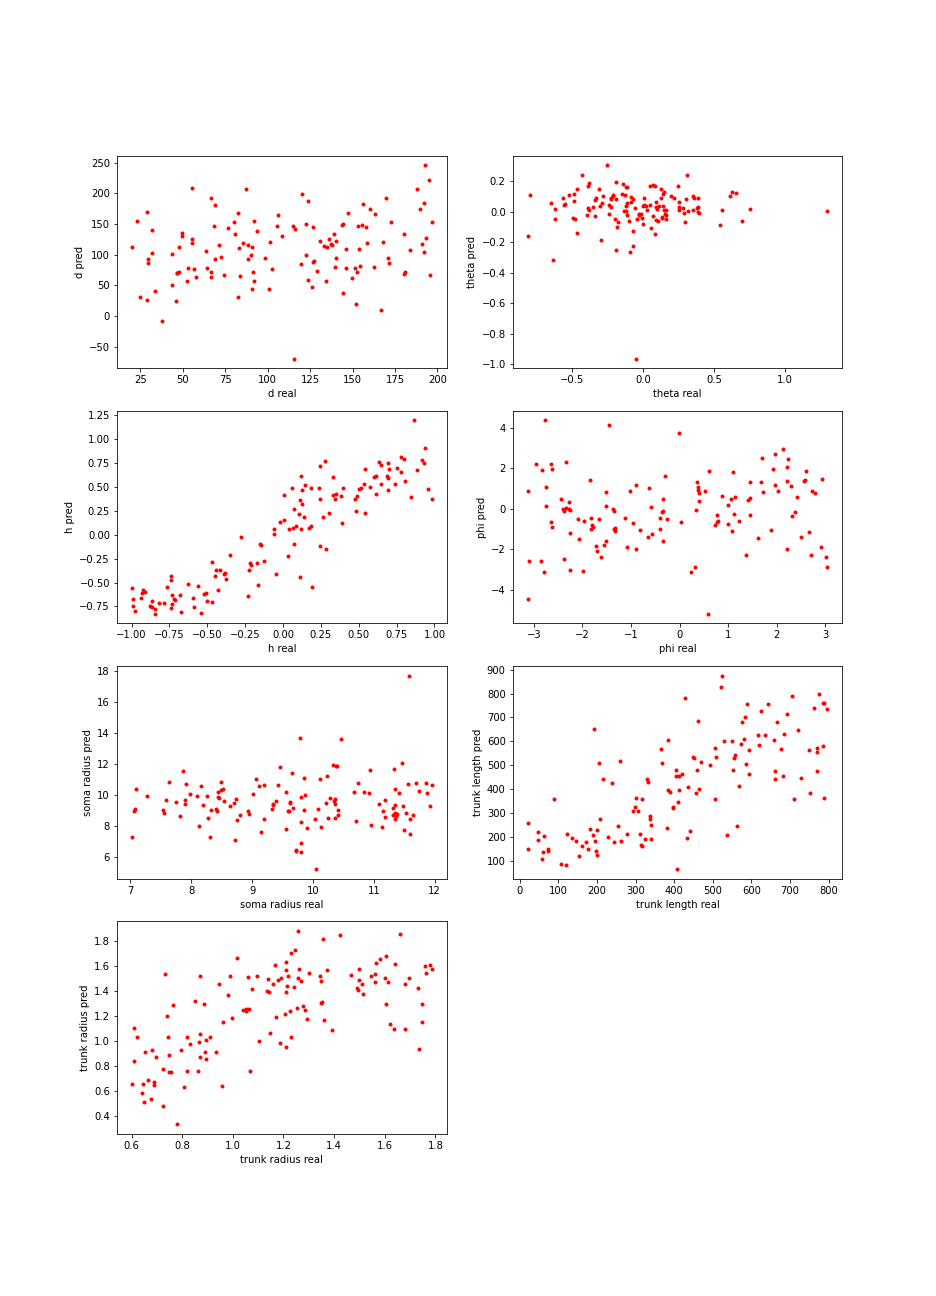

In [12]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(13, 18))

ax_d = plt.subplot(421)
ax_d.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')

ax_t = plt.subplot(422)
ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')

ax_h = plt.subplot(423)
ax_h.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(424)
ax_p.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

ax_lt = plt.subplot(425)
ax_lt.scatter(y[:,4], output[:,4], c='red', marker='.')
ax_lt.set_xlabel('soma radius real')
ax_lt.set_ylabel('soma radius pred')

ax_lt = plt.subplot(426)
ax_lt.scatter(y[:,5], output[:,5], c='red', marker='.')
ax_lt.set_xlabel('trunk length real')
ax_lt.set_ylabel('trunk length pred')

ax_lt = plt.subplot(427)
ax_lt.scatter(y[:,6], output[:,6], c='red', marker='.')
ax_lt.set_xlabel('trunk radius real')
ax_lt.set_ylabel('trunk radius pred')


plt.show()

In [ ]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.show()